Xi = 0.12361284651454937 W_r = 0.40569789967227576


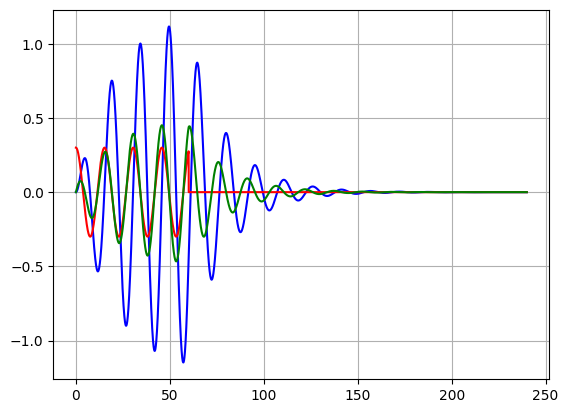

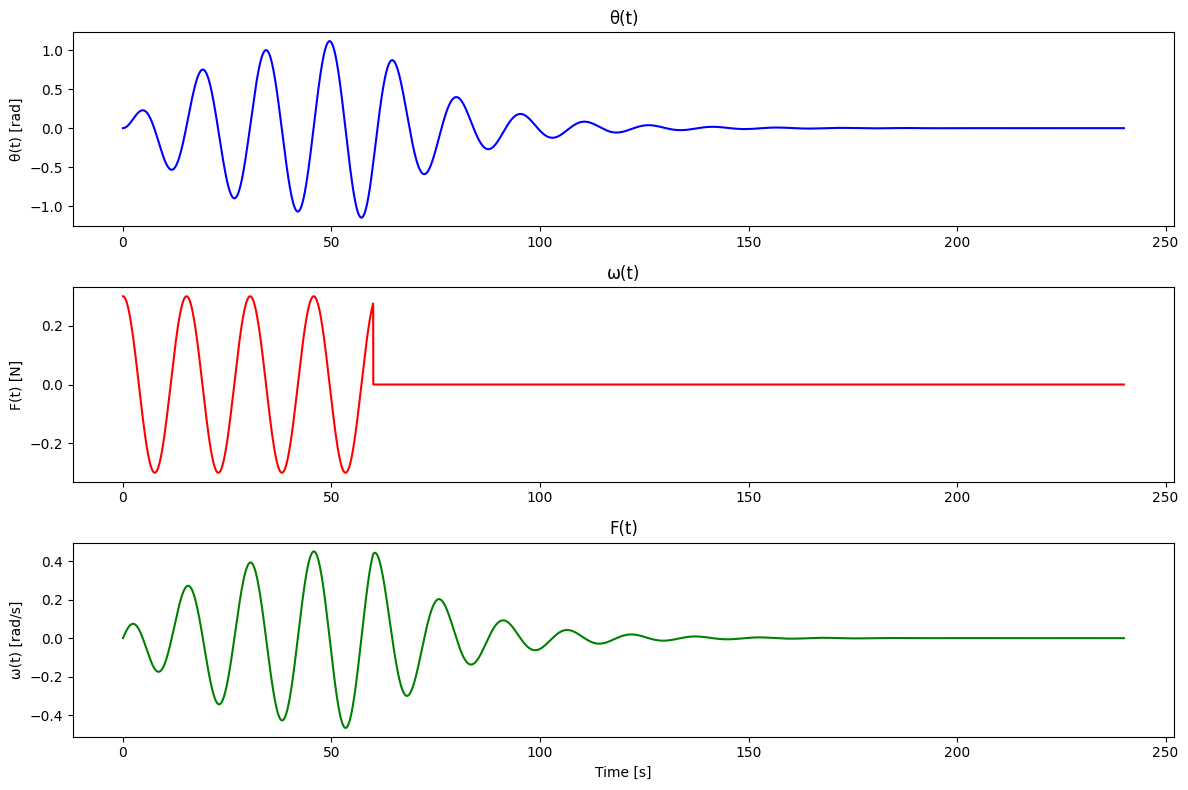

In [1]:
#Plotting the angle, angular velocity, and external force as functions of time

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv  # for linear algebra e.g matrix inversion
from math import *

def G(t, y): 
    F[0] = compute_F0(t)  # driving force
    return inv_A.dot(F-B.dot(y))  # matrix multiplication A^-1 * (F - B*y)

def RK4(t, y, delta_t): 
    k1 = G(t, y)
    k2 = G(t+0.5*delta_t, y+0.5*delta_t*k1)
    k3 = G(t+0.5*delta_t, y+0.5*delta_t*k2)
    k4 = G(t+delta_t, y+delta_t*k3)
    
    return k1/6.0 + 2.0*k2/6.0 + 2.0*k3/6.0 + k4/6.0
    # return k1

# Constants
L = 2.0  # meters
phi = 0.05  # meters
thickness = 0.005  # meters
m = 5.89  # kg (계산된 유체 무게)
k = 1.0  # N/m (가상 스프링 상수)
w = np.sqrt(k / m)
c=0.6
# 시간 따라서 외력 바뀜
def compute_F0(t):
    return 0.3 * np.cos(omega * t) if t <= 60 else 0.0
omega = sqrt(k/m)
xi = 0.5*c*1./(sqrt(m*k))
# Ensure the argument to sqrt is non-negative
arg = 1 - 2*xi*xi
if arg < 0:
    omega_res = 0  # Set to 0 if the argument is negative
else:
    omega_res = omega * sqrt(arg)
print("Xi =",xi,"W_r =", omega_res)

delta_t = 0.001
time = np.arange(0, 240, delta_t)



# init condition
x0 = 0.0
v0 = 0.0

y = np.array([v0, x0 ])  # velocity, position

A = np.array([[ m, 0.0 ],
              [ 0.0, 1.0 ]])  # 2x2 matrix

B = np.array([[ c, k ],
              [ -1.0, 0.0 ]])  # 2x2 matrix

F0 = compute_F0(0)  # Initialize F0 with a scalar value
F = np.array([F0, 0.0])  # driving force

XX=[]  # result list
FF=[]  # result list
VV=[]  # result list for velocity

inv_A = inv(A)

# time step
for t in time :
    y = y + delta_t * RK4(t, y, delta_t)
    XX.append(y[1])
    FF.append(F[0])
    VV.append(y[0])
# plotting
plt.grid(True)
plt.plot(time, XX,'b',time,FF,'r',time,VV,'g')
plt.show()
# 결과 그래프 출력
plt.figure(figsize=(12, 8))

plt.subplot(3,1,1)
plt.plot(time, XX,'b')
plt.ylabel("θ(t) [rad]")
plt.title("θ(t)")

plt.subplot(3,1,2)
plt.plot(time,FF,'r')
plt.ylabel("F(t) [N]")
plt.title("ω(t)")

plt.subplot(3,1,3)
plt.plot(time,VV,'g')
plt.ylabel("ω(t) [rad/s]")
plt.xlabel("Time [s]")
plt.title("F(t)")

plt.tight_layout()
plt.show()



In [8]:
import pygame
import math
import sys

# pygame 초기화
pygame.init()

# 화면 설정
WIDTH, HEIGHT = 800, 600
screen = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption('Oscillating Cylinder Simulation')

# 시계 설정
clock = pygame.time.Clock()
FPS = 60

# 진자 속성 설정
pivot = (WIDTH//2, 100)  # 회전 중심
length = 200             # 문제 조건에 따른 원통 길이
angle = math.radians(0)  # 초기 각도
angular_velocity = 0
gravity = 9.81 / 1000    # 중력 가속도 (스케일 조정)
damping = 0.995          # 마찰 및 공기 저항으로 인한 감쇠

# 액체 속성
fluid_level = 1.0        # 1.0 (full)에서 0.0 (empty)까지
leak_rate = 0.0008       # 액체가 새는 속도

# 외력 설정
external_force_period = 120
external_force_magnitude = 0.0015

frame_count = 0
knife_detached = False

running = True
while running:
    clock.tick(FPS)
    frame_count += 1

    # 이벤트 처리
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

    # 외부 힘 적용 및 제거 조건 설정
    if not knife_detached:
        if frame_count % external_force_period < external_force_period//2:
            external_force = external_force_magnitude
        else:
            external_force = -external_force_magnitude

        # 특정 각도를 초과하면 나이프 제거
        if abs(math.degrees(angle)) > 60:
            knife_detached = True
    else:
        external_force = 0
        if fluid_level > 0:
            fluid_level -= leak_rate
        else:
            fluid_level = 0

    # 질량 감소로 인한 길이 변화 반영
    effective_length = length - (1 - fluid_level) * 80

    # 각가속도 계산
    angular_acceleration = (-gravity / effective_length) * math.sin(angle) + external_force

    angular_velocity += angular_acceleration
    angular_velocity *= damping
    angle += angular_velocity

    # 화면 초기화
    screen.fill((255, 255, 255))

    # 회전 각도
    angle_deg = math.degrees(-angle)

    # 원통 그리기
    rect_width, rect_height = 40, effective_length
    rect = pygame.Surface((rect_width, rect_height), pygame.SRCALPHA)

    # 액체 부분 그리기
    pygame.draw.rect(
        rect,
        (0, 128, 255),
        (0, rect_height * (1 - fluid_level), rect_width, rect_height * fluid_level)
    )

    # 원통 테두리
    pygame.draw.rect(
        rect,
        (0, 0, 0),
        (0, 0, rect_width, rect_height),
        3
    )

    # 회전 (원통 상단을 회전 중심으로 설정)
    rotated_rect = pygame.transform.rotate(rect, angle_deg)
    rect_pos = rotated_rect.get_rect()
    rect_pos.midtop = pivot  # 피벗이 원통의 상단 중앙에 위치하도록 정확히 설정

    # 원통 출력
    screen.blit(rotated_rect, rect_pos.topleft)

    # 힌지 그리기
    pygame.draw.circle(screen, (0, 0, 0), pivot, 6)

    # 화면 업데이트
    pygame.display.flip()

pygame.quit()
sys.exit()


SystemExit: 

/home/midori/github/Assignment_archive/전산물리학/25-mid-exam/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3675: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
